In [2]:
!pip install pandas numpy scikit-learn imbalanced-learn tensorflow keras nltk spacy wordcloud matplotlib seaborn

In [3]:
!python -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 46.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


 CARGANDO DATOS
 Dataset: (1731, 5)

 Distribución de etiquetas:
   HS:  756 ( 43.7%)
   TR:  519 ( 30.0%)
   AG:  662 ( 38.2%)

 DICCIONARIO DE PALABRAS TÓXICAS
 46 palabras tóxicas identificadas

 CREANDO VERSIONES DE TEXTO
 Generando versiones de texto...
 1730 textos válidos en todas las versiones

 CONFIGURACIONES A PROBAR
 12 configuraciones preparadas

 ENTRENANDO TODAS LAS CONFIGURACIONES

[1/12]  v1_tfidf_5k
   F1-Macro: 0.7288 | HS: 0.7518 | TR: 0.7596 | AG: 0.6751

[2/12]  v1_tfidf_count
   F1-Macro: 0.7495 | HS: 0.7568 | TR: 0.7841 | AG: 0.7077

[3/12]  v1_4grams
   F1-Macro: 0.7317 | HS: 0.7544 | TR: 0.7656 | AG: 0.6751

[4/12]  v2_tfidf_5k
   F1-Macro: 0.7148 | HS: 0.7122 | TR: 0.7343 | AG: 0.6979

[5/12]  v2_tfidf_count
   F1-Macro: 0.7220 | HS: 0.7211 | TR: 0.7545 | AG: 0.6905

[6/12]  v2_4grams
   F1-Macro: 0.7185 | HS: 0.7174 | TR: 0.7404 | AG: 0.6979

[7/12]  v3_tfidf_5k
   F1-Macro: 0.7362 | HS: 0.7384 | TR: 0.7596 | AG: 0.7107

[8/12]  v3_tfidf_count
   F1-Macro: 0

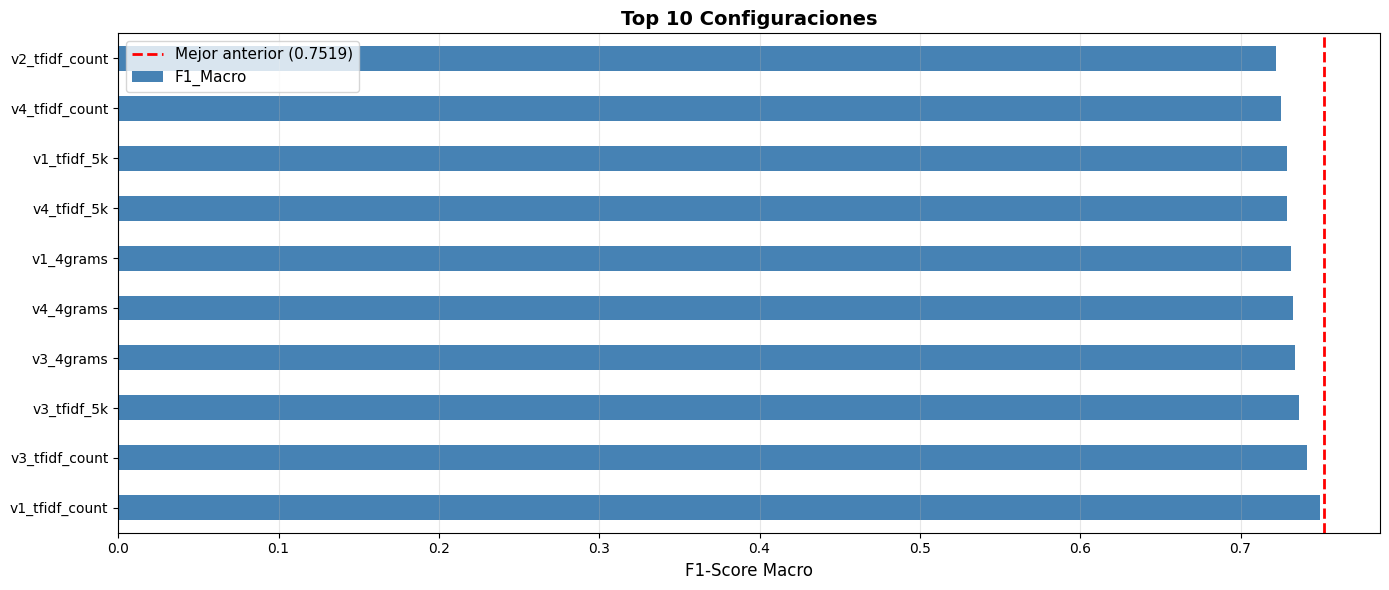


 MEJOR CONFIGURACIÓN
Nombre: v1_tfidf_count
F1-Macro: 0.7495

Detalle por etiqueta:
   HS: 0.7568
   TR: 0.7841
   AG: 0.7077

 Mejora sobre anterior: +-0.32%
 Mejora total sobre baseline: +0.19%

 REPORTE DETALLADO

──────────────────────────────────────────────────────────────────────
 HS
──────────────────────────────────────────────────────────────────────
              precision    recall  f1-score   support

    Negativo       0.81      0.83      0.82       195
    Positivo       0.77      0.74      0.76       151

    accuracy                           0.79       346
   macro avg       0.79      0.79      0.79       346
weighted avg       0.79      0.79      0.79       346


──────────────────────────────────────────────────────────────────────
 TR
──────────────────────────────────────────────────────────────────────
              precision    recall  f1-score   support

    Negativo       0.92      0.87      0.89       240
    Positivo       0.74      0.84      0.78       106

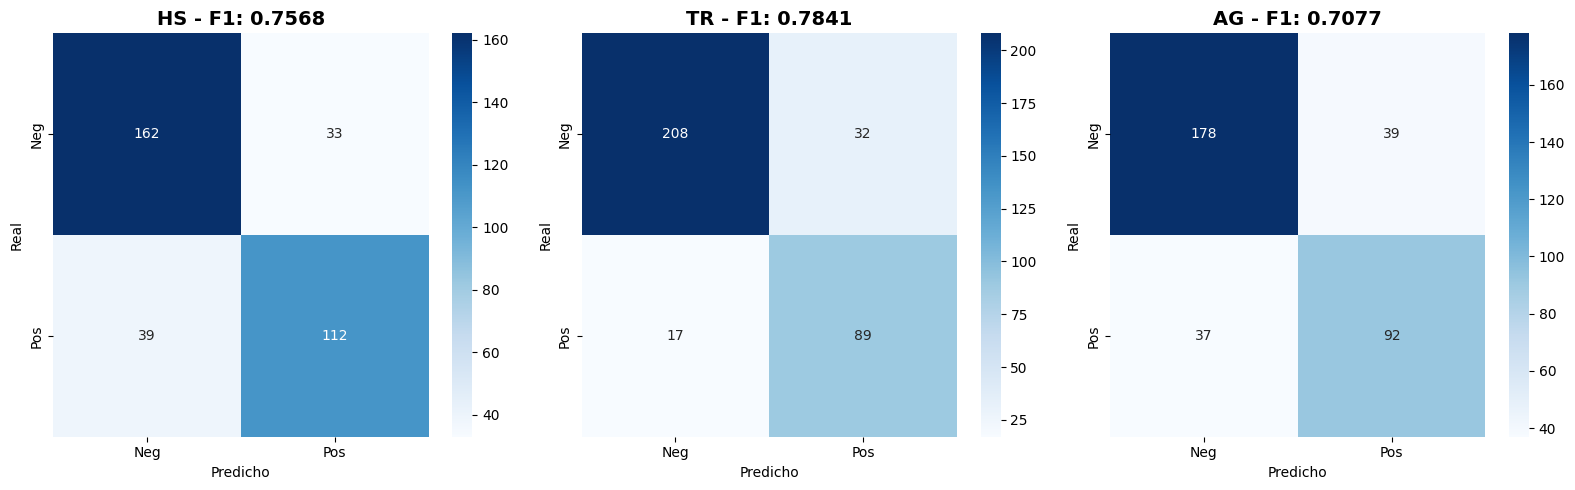


 GUARDANDO
 vectorizer_tfidf_final.pkl
 vectorizer_count_final.pkl
 model_final.pkl
 config_final.pkl

 PREDICIENDO: toxic_test.csv
 1154 textos

 Archivo: submission_final.csv

 Distribución:
   HS:  475 ( 41.2%)
   TR:  380 ( 32.9%)
   AG:  415 ( 36.0%)

 COMPLETADO
 Configuración: v1_tfidf_count
 F1-Score: 0.7495
 Mejora total: +0.19%


In [4]:
# ============================================
# IMPORTACIONES
# ============================================
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import spacy

# Preprocesamiento
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Modelo
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

# Métricas
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack
import pickle

# Descargar recursos
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

# Cargar Spacy y Stemmer
nlp = spacy.load('es_core_news_sm', disable=['parser', 'ner'])
stemmer = SnowballStemmer('spanish')

# ============================================
# 1. CARGAR DATOS
# ============================================
print("="*70)
print(" CARGANDO DATOS")
print("="*70)

df = pd.read_csv('toxic_train.csv', sep=';')
print(f" Dataset: {df.shape}")

# Limpiar datos
df['text'] = df['text'].fillna('')
for col in ['HS', 'TR', 'AG']:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

print(f"\n Distribución de etiquetas:")
print(f"   HS: {df['HS'].sum():4d} ({df['HS'].mean()*100:5.1f}%)")
print(f"   TR: {df['TR'].sum():4d} ({df['TR'].mean()*100:5.1f}%)")
print(f"   AG: {df['AG'].sum():4d} ({df['AG'].mean()*100:5.1f}%)")

# ============================================
# 2. DICCIONARIO DE PALABRAS TÓXICAS
# ============================================
print("\n" + "="*70)
print(" DICCIONARIO DE PALABRAS TÓXICAS")
print("="*70)

# Palabras ofensivas comunes en español (expandido)
palabras_toxicas = {
    'idiota', 'estupido', 'estúpido', 'imbecil', 'imbécil', 'tonto', 'tonta',
    'pendejo', 'pendeja', 'marica', 'maricon', 'maricón',
    'puto', 'puta', 'perra', 'perro', 'zorra', 'zorro',
    'mierda', 'cagar', 'cagada', 'asco', 'asqueroso',
    'odio', 'odiar', 'muerte', 'matar', 'muere', 'muerto', 'muerta',
    'joder', 'jodido', 'cabron', 'cabrón', 'hijueputa',
    'basura', 'escoria', 'rata', 'cerdo', 'cerda',
    'verga', 'carajo', 'coño', 'chingar', 'maldito', 'maldita'
}

print(f" {len(palabras_toxicas)} palabras tóxicas identificadas")

# ============================================
# 3. MÚLTIPLES VERSIONES DE PREPROCESAMIENTO
# ============================================
print("\n" + "="*70)
print(" CREANDO VERSIONES DE TEXTO")
print("="*70)

stop_words = set(stopwords.words('spanish'))
# Mantener palabras negativas importantes
stop_words_reducido = stop_words - {'no', 'ni', 'nunca', 'nada', 'nadie', 'ninguno', 'sin', 'tampoco'}

def limpiar_basico(texto):
    """Limpieza básica"""
    texto = texto.lower()
    texto = re.sub(r'http\S+|www\S+', '', texto)
    texto = re.sub(r'@\w+', '', texto)
    texto = re.sub(r'#(\w+)', r'\1', texto)
    texto = re.sub(r'(.)\1{3,}', r'\1\1', texto)
    texto = re.sub(r'[^a-záéíóúñü\s]', ' ', texto)
    texto = re.sub(r'\s+', ' ', texto).strip()
    return texto

def normalizar_toxicas(texto):
    """Normaliza palabras tóxicas con variaciones"""
    texto_lower = texto.lower()
    # Normalizar variaciones comunes
    texto_lower = re.sub(r'p[e3]nd[e3]j[o0]', 'pendejo', texto_lower)
    texto_lower = re.sub(r'[i1]d[i1][o0]t[a4]', 'idiota', texto_lower)
    texto_lower = re.sub(r'm[i1][e3]rd[a4]', 'mierda', texto_lower)
    texto_lower = re.sub(r'p[u\*][t\*][o0a4]', 'puto', texto_lower)
    texto_lower = re.sub(r'\*+', '', texto_lower)  # Remover censura
    return texto_lower

def preprocesar_version1(texto):
    """Versión 1: Sin stopwords, sin stemming"""
    texto = normalizar_toxicas(texto)
    texto = limpiar_basico(texto)
    doc = nlp(texto)
    tokens = [
        token.text for token in doc
        if not token.is_stop
        and token.text not in stop_words_reducido
        and len(token.text) > 2
        and token.is_alpha
    ]
    return ' '.join(tokens)

def preprocesar_version2(texto):
    """Versión 2: Con stemming"""
    texto = normalizar_toxicas(texto)
    texto = limpiar_basico(texto)
    doc = nlp(texto)
    tokens = [
        stemmer.stem(token.text) for token in doc
        if not token.is_stop
        and token.text not in stop_words_reducido
        and len(token.text) > 2
        and token.is_alpha
    ]
    return ' '.join(tokens)

def preprocesar_version3(texto):
    """Versión 3: Menos restrictivo con stopwords"""
    texto = normalizar_toxicas(texto)
    texto = limpiar_basico(texto)
    doc = nlp(texto)
    tokens = [
        token.text for token in doc
        if len(token.text) > 2
        and token.is_alpha
    ]
    return ' '.join(tokens)

def preprocesar_version4(texto):
    """Versión 4: Stemming + menos restrictivo"""
    texto = normalizar_toxicas(texto)
    texto = limpiar_basico(texto)
    doc = nlp(texto)
    tokens = [
        stemmer.stem(token.text) for token in doc
        if len(token.text) > 2
        and token.is_alpha
    ]
    return ' '.join(tokens)

# Aplicar todas las versiones
print(" Generando versiones de texto...")
df['v1'] = df['text'].apply(preprocesar_version1)
df['v2'] = df['text'].apply(preprocesar_version2)
df['v3'] = df['text'].apply(preprocesar_version3)
df['v4'] = df['text'].apply(preprocesar_version4)

# Eliminar textos vacíos
for col in ['v1', 'v2', 'v3', 'v4']:
    df = df[df[col].str.len() > 0]

df = df.reset_index(drop=True)
print(f" {len(df)} textos válidos en todas las versiones")

# ============================================
# 4. CONFIGURACIONES AVANZADAS
# ============================================
print("\n" + "="*70)
print(" CONFIGURACIONES A PROBAR")
print("="*70)

y = df[['HS', 'TR', 'AG']].values

configs = []

# Configuraciones con diferentes versiones de texto
for version_name, version_col in [('v1', 'v1'), ('v2', 'v2'), ('v3', 'v3'), ('v4', 'v4')]:

    # Config A: TF-IDF expandido
    configs.append({
        'nombre': f'{version_name}_tfidf_5k',
        'texto': version_col,
        'vectorizers': [
            ('tfidf', TfidfVectorizer(
                max_features=5000,
                ngram_range=(1, 3),
                min_df=2,
                max_df=0.85,
                sublinear_tf=True,
                norm='l2'
            ))
        ],
        'lr_params': {'max_iter': 1500, 'C': 0.7, 'solver': 'saga', 'class_weight': 'balanced'}
    })

    # Config B: TF-IDF + Count
    configs.append({
        'nombre': f'{version_name}_tfidf_count',
        'texto': version_col,
        'vectorizers': [
            ('tfidf', TfidfVectorizer(
                max_features=4000,
                ngram_range=(1, 3),
                min_df=2,
                max_df=0.9,
                sublinear_tf=True
            )),
            ('count', CountVectorizer(
                max_features=1500,
                ngram_range=(1, 2),
                min_df=2,
                binary=True
            ))
        ],
        'lr_params': {'max_iter': 1500, 'C': 0.5, 'solver': 'saga', 'class_weight': 'balanced'}
    })

    # Config C: TF-IDF con 4-grams
    configs.append({
        'nombre': f'{version_name}_4grams',
        'texto': version_col,
        'vectorizers': [
            ('tfidf', TfidfVectorizer(
                max_features=4000,
                ngram_range=(1, 4),
                min_df=2,
                max_df=0.9,
                sublinear_tf=True
            ))
        ],
        'lr_params': {'max_iter': 1500, 'C': 0.6, 'solver': 'saga', 'class_weight': 'balanced'}
    })

print(f" {len(configs)} configuraciones preparadas")

# ============================================
# 5. ENTRENAR Y EVALUAR TODO
# ============================================
print("\n" + "="*70)
print(" ENTRENANDO TODAS LAS CONFIGURACIONES")
print("="*70)

resultados = {}

for i, config in enumerate(configs, 1):
    nombre = config['nombre']
    print(f"\n[{i}/{len(configs)}]  {nombre}")

    try:
        # Obtener texto
        X_text = df[config['texto']].values

        # Vectorizar
        X_features = []
        fitted_vectorizers = []

        for vec_name, vectorizer in config['vectorizers']:
            X_vec = vectorizer.fit_transform(X_text)
            X_features.append(X_vec)
            fitted_vectorizers.append((vec_name, vectorizer))

        # Combinar si hay múltiples vectorizers
        if len(X_features) > 1:
            X_combined = hstack(X_features)
        else:
            X_combined = X_features[0]

        # Split
        X_train, X_test, y_train, y_test = train_test_split(
            X_combined, y,
            test_size=0.2,
            random_state=42,
            stratify=y[:, 0]
        )

        # Entrenar
        lr_model = MultiOutputClassifier(
            LogisticRegression(**config['lr_params'], random_state=42)
        )
        lr_model.fit(X_train, y_train)

        # Evaluar
        y_pred = lr_model.predict(X_test)

        f1_macro = f1_score(y_test, y_pred, average='macro')
        f1_hs = f1_score(y_test[:, 0], y_pred[:, 0])
        f1_tr = f1_score(y_test[:, 1], y_pred[:, 1])
        f1_ag = f1_score(y_test[:, 2], y_pred[:, 2])

        resultados[nombre] = {
            'F1_Macro': f1_macro,
            'F1_HS': f1_hs,
            'F1_TR': f1_tr,
            'F1_AG': f1_ag,
            'config': config,
            'model': lr_model,
            'vectorizers': fitted_vectorizers,
            'texto_col': config['texto']
        }

        print(f"   F1-Macro: {f1_macro:.4f} | HS: {f1_hs:.4f} | TR: {f1_tr:.4f} | AG: {f1_ag:.4f}")

    except Exception as e:
        print(f"    Error: {e}")

# ============================================
# 6. TOP 10 MEJORES
# ============================================
print("\n" + "="*70)
print(" TOP 10 MEJORES CONFIGURACIONES")
print("="*70)

df_results = pd.DataFrame({
    nombre: {
        'F1_Macro': res['F1_Macro'],
        'F1_HS': res['F1_HS'],
        'F1_TR': res['F1_TR'],
        'F1_AG': res['F1_AG']
    }
    for nombre, res in resultados.items()
}).T.sort_values('F1_Macro', ascending=False)

print("\n" + df_results.head(10).to_string())

# Visualizar top 10
fig, ax = plt.subplots(figsize=(14, 6))
df_results.head(10)['F1_Macro'].plot(kind='barh', ax=ax, color='steelblue')
ax.set_xlabel('F1-Score Macro', fontsize=12)
ax.set_title('Top 10 Configuraciones', fontsize=14, fontweight='bold')
ax.axvline(x=0.7519, color='red', linestyle='--', linewidth=2, label='Mejor anterior (0.7519)')
ax.legend(fontsize=11)
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('top10_configs.png', dpi=150)
plt.show()

# ============================================
# 7. MEJOR CONFIGURACIÓN
# ============================================
mejor_nombre = df_results.index[0]
mejor_f1 = df_results['F1_Macro'].iloc[0]
mejor_config = resultados[mejor_nombre]

print(f"\n{'='*70}")
print(f" MEJOR CONFIGURACIÓN")
print(f"{'='*70}")
print(f"Nombre: {mejor_nombre}")
print(f"F1-Macro: {mejor_f1:.4f}")
print(f"\nDetalle por etiqueta:")
print(f"   HS: {mejor_config['F1_HS']:.4f}")
print(f"   TR: {mejor_config['F1_TR']:.4f}")
print(f"   AG: {mejor_config['F1_AG']:.4f}")

mejora = (mejor_f1 - 0.7519) / 0.7519 * 100
print(f"\n✨ Mejora sobre anterior: +{mejora:.2f}%")
mejora_total = (mejor_f1 - 0.7481) / 0.7481 * 100
print(f"✨ Mejora total sobre baseline: +{mejora_total:.2f}%")

# ============================================
# 8. REPORTE DETALLADO
# ============================================
print(f"\n{'='*70}")
print(f" REPORTE DETALLADO")
print(f"{'='*70}")

# Re-entrenar para obtener predicciones
texto_col = mejor_config['texto_col']
X_text_best = df[texto_col].values

X_features_best = []
for vec_name, vectorizer in mejor_config['vectorizers']:
    X_vec = vectorizer.transform(X_text_best)
    X_features_best.append(X_vec)

if len(X_features_best) > 1:
    X_combined_best = hstack(X_features_best)
else:
    X_combined_best = X_features_best[0]

X_train, X_test, y_train, y_test = train_test_split(
    X_combined_best, y,
    test_size=0.2,
    random_state=42,
    stratify=y[:, 0]
)

y_pred_best = mejor_config['model'].predict(X_test)

for i, label in enumerate(['HS', 'TR', 'AG']):
    print(f"\n{'─'*70}")
    print(f" {label}")
    print(f"{'─'*70}")
    print(classification_report(y_test[:, i], y_pred_best[:, i],
                                target_names=['Negativo', 'Positivo']))

# Matrices
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i, label in enumerate(['HS', 'TR', 'AG']):
    cm = confusion_matrix(y_test[:, i], y_pred_best[:, i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['Neg', 'Pos'], yticklabels=['Neg', 'Pos'])
    axes[i].set_title(f'{label} - F1: {f1_score(y_test[:, i], y_pred_best[:, i]):.4f}',
                     fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Real')
    axes[i].set_xlabel('Predicho')

plt.tight_layout()
plt.savefig('confusion_final.png', dpi=150)
plt.show()

# ============================================
# 9. GUARDAR
# ============================================
print(f"\n{'='*70}")
print(" GUARDANDO")
print(f"{'='*70}")

for i, (vec_name, vec) in enumerate(mejor_config['vectorizers']):
    filename = f'vectorizer_{vec_name}_final.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(vec, f)
    print(f" {filename}")

with open('model_final.pkl', 'wb') as f:
    pickle.dump(mejor_config['model'], f)
print(" model_final.pkl")

with open('config_final.pkl', 'wb') as f:
    pickle.dump({
        'nombre': mejor_nombre,
        'f1': mejor_f1,
        'texto_col': texto_col,
        'vectorizers': [name for name, _ in mejor_config['vectorizers']]
    }, f)
print(" config_final.pkl")

# ============================================
# 10. PREDICCIÓN
# ============================================
# Determinar qué función de preprocesamiento usar
preproc_map = {
    'v1': preprocesar_version1,
    'v2': preprocesar_version2,
    'v3': preprocesar_version3,
    'v4': preprocesar_version4
}
preproc_func = preproc_map[texto_col]

def predecir_dataset(csv_path, sep=';', encoding='ISO-8859-1'):
    print(f"\n{'='*70}")
    print(f" PREDICIENDO: {csv_path}")
    print(f"{'='*70}")

    df_new = pd.read_csv(csv_path, sep=sep, encoding=encoding)
    print(f" {len(df_new)} textos")

    # Preprocesar con la función correcta
    df_new['text_processed'] = df_new['text'].fillna('').apply(preproc_func)

    # Vectorizar
    X_features_new = []
    for vec_name, vectorizer in mejor_config['vectorizers']:
        X_vec = vectorizer.transform(df_new['text_processed'])
        X_features_new.append(X_vec)

    if len(X_features_new) > 1:
        X_new = hstack(X_features_new)
    else:
        X_new = X_features_new[0]

    # Predecir
    predictions = mejor_config['model'].predict(X_new)

    df_output = df_new[['id']].copy()
    df_output['HS'] = predictions[:, 0]
    df_output['TR'] = predictions[:, 1]
    df_output['AG'] = predictions[:, 2]

    return df_output

df_submission = predecir_dataset('toxic_test.csv')
df_submission.to_csv('submission_final.csv', index=False)

print(f"\n Archivo: submission_final.csv")
print(f"\n Distribución:")
print(f"   HS: {df_submission['HS'].sum():4d} ({df_submission['HS'].mean()*100:5.1f}%)")
print(f"   TR: {df_submission['TR'].sum():4d} ({df_submission['TR'].mean()*100:5.1f}%)")
print(f"   AG: {df_submission['AG'].sum():4d} ({df_submission['AG'].mean()*100:5.1f}%)")

print(f"\n{'='*70}")
print(" COMPLETADO")
print(f"{'='*70}")
print(f" Configuración: {mejor_nombre}")
print(f" F1-Score: {mejor_f1:.4f}")
print(f" Mejora total: +{mejora_total:.2f}%")
print(f"{'='*70}")